In [32]:
# the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_auc_score, roc_curve, f1_score, classification_report
from sklearn.metrics import confusion_matrix, SCORERS

# preprocessing
from sklearn.preprocessing import StandardScaler

# Scale, Train, Fit, and Predict

In [12]:
# read in training + val set
X = pd.read_csv('./data/processed_second_X.csv')
y = pd.read_csv('./data/processed_second_y.csv')

In [13]:
X_hold = pd.read_csv('./data/processed_HOLDOUT_X.csv')
y_hold = pd.read_csv('./data/processed_HOLDOUT_y.csv')

In [14]:
y = np.array(y).ravel()

In [15]:
sts = StandardScaler()
sts.fit(X)

StandardScaler()

In [16]:
X_train_scale = sts.transform(X)
X_hold_scale = sts.transform(X_hold)

In [17]:
lm_l1_weight_g = LogisticRegression(C=.001, 
                        solver='liblinear',
                        penalty='l1',
                        class_weight={1:5,0:1}).fit(X_train_scale, y)

In [21]:
yhat = lm_l1_weight_g.predict(X_hold_scale)

# Interlude for False Negatives

In [40]:
full = X_hold.merge(y_hold,left_index=True,right_index=True)
yhat_df = pd.DataFrame(yhat,columns=['yhat'])
full_yhat = full.merge(yhat_df,left_index=True,right_index=True)

In [49]:
df_cat = pd.read_csv('./data/categorical_df.csv')
df_cat_drop = df_cat.drop(columns=['diabetes_mellitus'],axis=1)

In [45]:
false_negatives = full_yhat[(full_yhat['diabetes_mellitus'] == 1) & (full_yhat['yhat'] == 0)].copy()
false_negatives.drop(['ethnicity_African American','ethnicity_Caucasian'],axis=1,inplace = True)

In [51]:
false_neg_df = false_negatives.merge(df_cat_drop,how='left',left_index=True,right_index=True)

In [52]:
false_neg_df.to_csv('./data/false_negatives.csv')

# Interlude Over

In [107]:
print("L1 Regularization:")
print("Precision: {:6.4f},   Recall: {:6.4f},\nF1: {:6.4f}\n".format(precision_score(y_hold, yhat), 
                                                     recall_score(y_hold, yhat),
                                                     f1_score(y_hold,yhat)))

L1 Regularization:
Precision: 0.4080,   Recall: 0.7911,
F1: 0.5383



In [54]:
print('Hold Out Accuracy (L1):',lm_l1_weight_g.score(X_hold_scale,y_hold))

Hold Out Accuracy (L1): 0.7120851259987707


In [55]:
def make_confusion_matrix(model,threshold=0.5):
    y_hat = (model.predict_proba(X_hold_scale)[:, 1] >= threshold)
    diabetes_confusion = confusion_matrix(y_hold, y_hat)
    
    plt.figure(dpi=200)
    sns.heatmap(diabetes_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['pred no', 'pred yes'],
           yticklabels=['actual no', 'actual yes']);
    plt.title('Confusion Matrix -- Final')
    plt.savefig('./project-checkpoints/final_model_matrix.png')

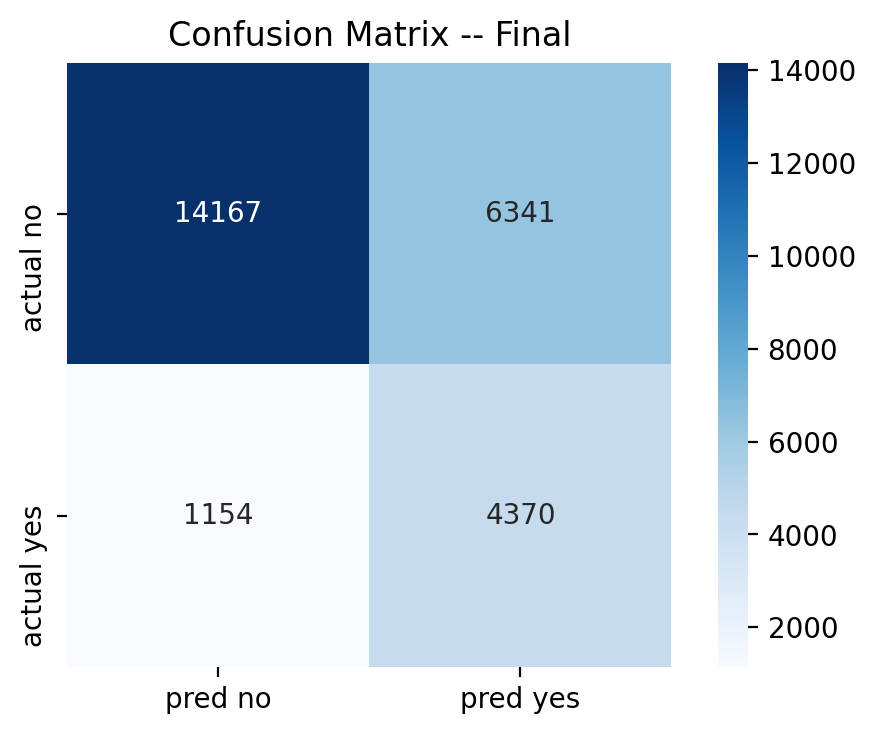

In [56]:
make_confusion_matrix(lm_l1_weight_g)

# Feature Importance

In [79]:
zipped = list(zip(X_hold.columns,lm_l1_weight_g.coef_[0,:]))
zorted = sorted(zipped,key=lambda x:x[1],reverse=True)

In [91]:
listicle = zorted[:13] + zorted[-6:]
feature, coef = list(zip(*listicle))

In [105]:
feat_array = pd.DataFrame(feature,columns=['Features'])
coef_array = pd.DataFrame(coef,columns=['Coef'])
feature_coef = feat_array.merge(coef_array,left_index=True,right_index=True)

In [106]:
feature_coef.to_csv('./data/feature_importance.csv')